# Single shot detection (SSD)

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json, pdb
from matplotlib import patches, patheffects

In [3]:
torch.backends.cudnn.benchmark = True

## Dataset

In [4]:
PATH = Path('data/pascal_voc/')
trn_json = json.load((PATH/'pascal_train2007.json').open())

In [5]:
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
FN, ID, IMG_ID, CAT_ID, BBOX, NAME = 'file_name', 'id', 'image_id', 'category_id', 'bbox', 'name'

In [6]:
cats = dict((o[ID], o[NAME]) for o in trn_json[CATEGORIES])

In [7]:
train_fn = dict((o[ID], o[FN]) for o in trn_json[IMAGES])

In [8]:
train_ids = [o[ID] for o in trn_json[IMAGES]]

In [9]:
JPEGS = 'VOC2007/JPEGImages'

In [10]:
IMPATH = PATH/JPEGS

In [11]:
def convert_bb_to_np(bb):
    return np.array([bb[1], bb[0], bb[1] + bb[3] - 1, bb[0] + bb[2] - 1])

def convert_bb_to_VOC(bb):
    return np.array([bb[1], bb[0], bb[3]-bb[1] + 1, bb[2]-bb[0] + 1])

In [12]:
def get_train_annot():
    train_annotations = collections.defaultdict(lambda: [])
    for o in trn_json[ANNOTATIONS]:
        if not o['ignore']:
            bb = o[BBOX]
            bb = convert_bb_to_np(bb)
            train_annotations[o[IMG_ID]].append((bb, o[CAT_ID]))
    return train_annotations

In [13]:
train_annot = get_train_annot()

**Convenience functions for plotting:**

In [14]:
def show_img(img, figsize=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img),
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    return ax

In [15]:
def draw_outline(matplt_plot_obj, lw):    matplt_plot_obj.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])

In [16]:
def draw_rect(ax, bbox, color='white'):
    patch = ax.add_patch(patches.Rectangle(bbox[:2], *bbox[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

In [35]:
def draw_text(ax, xy, text, sz=14, color='white'):
    pass
    txt = ax.text(*xy, text, verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(txt, 1)

In [36]:
def draw_image(im, annot):
    ax = show_img(im, figsize=(16, 8))
    for bbox, cat in annot:
        bb = convert_bb_to_VOC(bbox)
        draw_rect(ax, bb)
        draw_text(ax, bb[:2], cats[cat], sz=16)
        
def draw_idx(i):
    im_annot = train_annot[i]
    im = open_image(IMPATH/train_fn[i])
    draw_image(im, im_annot)

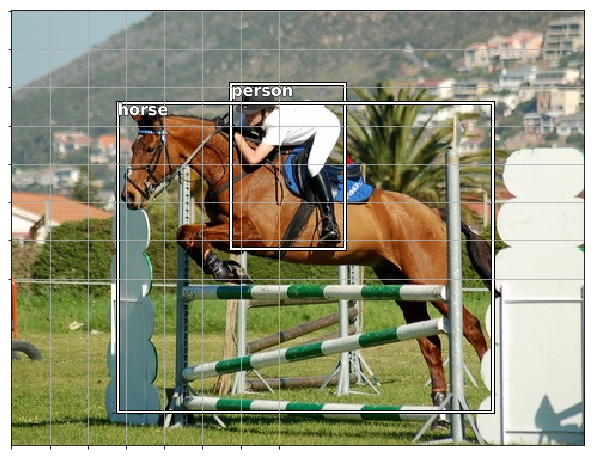

In [37]:
draw_idx(17)

## Step 1: Multi label classification

In [38]:
MULTI_CLASS_CSV = PATH/'tmp/multi_class.csv'

In [40]:
train_annot[17]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

Use a set because we only want the label once, not for every person in an image for instance.

In [43]:
multi_labels = [set([cats[p[1]] for p in train_annot[i]]) for i in train_ids]

In [45]:
multi_labels_string = [' '.join(str(p) for p in o) for o in multi_labels]

In [47]:
df = pd.DataFrame({'fn': [train_fn[o] for o in train_ids], 'clas': multi_labels_string}, columns=['fn', 'clas'])

In [49]:
df.head(2)

,fn,clas
0,000012.jpg,car
1,000017.jpg,horse person


In [48]:
df.to_csv(MULTI_CLASS_CSV, index=False)

In [393]:
model = resnet34
sz = 224
bs = 64

In [51]:
tfms = tfms_from_model(model, sz, crop_type=CropType.NO)

In [52]:
modeldata = ImageClassifierData.from_csv(PATH, JPEGS, MULTI_CLASS_CSV, tfms=tfms)

In [53]:
learn = ConvLearner.pretrained(model, modeldata)

/home/fabiograetz/anaconda3/envs/deeplearning/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [54]:
learn.opt_fn = optim.Adam

In [55]:
learn.lr_find(start_lr=1e-5, end_lr=100)

epoch      trn_loss   val_loss   <lambda>                  
    0      1.418716   9.615595   0.652     



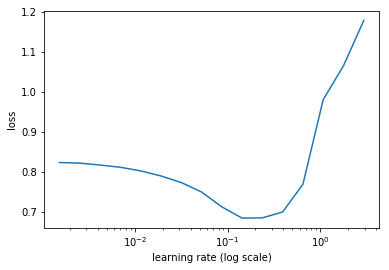

In [56]:
learn.sched.plot()

In [57]:
lr = 2e-2

In [58]:
learn.fit(lrs=lr, n_cycle=1, cycle_len=3, use_clr=(32,5))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.324668   0.13681    0.9569    
    1      0.172721   0.078412   0.975                     
    2      0.116054   0.07622    0.9754                    



[0.07622028124332428, 0.975400007724762]

In [59]:
learn.fit(lrs=lr, n_cycle=1, cycle_len=1, use_clr=(32,5))

epoch      trn_loss   val_loss   <lambda>                   
    0      0.088654   0.086651   0.9722    



[0.08665119564533233, 0.9722000031471253]

In [60]:
lrs = np.array([lr/100, lr/10, lr])

In [61]:
learn.freeze_to(-2)

In [62]:
learn.lr_find(lrs/1000)

 84%|████████▍ | 27/32 [00:04<00:00,  6.28it/s, loss=0.483] 


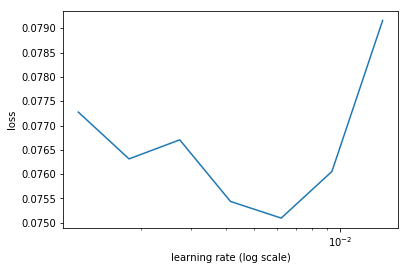

In [69]:
learn.sched.plot(n_skip_end=9)

In [70]:
learn.fit(lrs=lrs/10, n_cycle=1, cycle_len=5, use_clr=(32,5))

epoch      trn_loss   val_loss   <lambda>                   
    0      0.073234   0.087106   0.9714    
    1      0.055905   0.078425   0.9745                     
    2      0.039185   0.07948    0.9742                     
    3      0.028038   0.078738   0.9748                     
    4      0.019856   0.076496   0.975                      



[0.07649596083164215, 0.975000018119812]

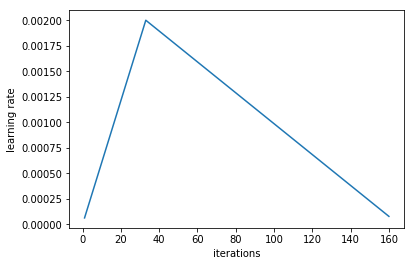

In [71]:
learn.sched.plot_lr()

In [72]:
learn.save('multi_class')

In [73]:
learn.load('multi_class')

In [101]:
y = learn.predict()
x, _ = next(iter(modeldata.val_dl))

In [102]:
x = x.data.cpu().numpy()

In [103]:
x.shape, y.shape

((64, 3, 224, 224), (500, 20))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


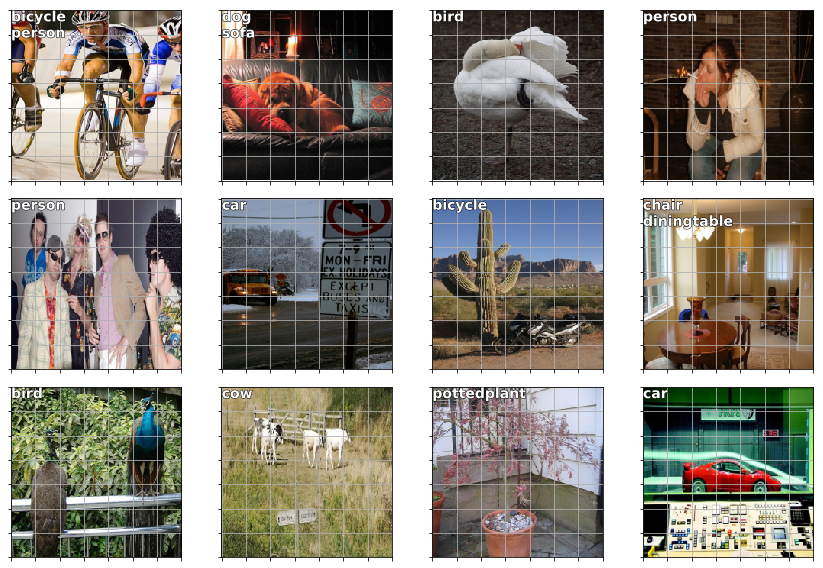

In [111]:
figure, axes = plt.subplots(3, 4, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    img = modeldata.val_ds.denorm(x)[i]
    yy = np.nonzero(y[i]>0.4)[0]
    lbl = '\n'.join(modeldata.classes[o] for o in yy)
    ax = show_img(img, ax=ax)
    draw_text(ax, (0,0), lbl)
plt.tight_layout()

## Bbox per anchor box

In the notebook "Object detection" we produced an output vector with length $(4 + n_{cats})$ to predict the 4 coordinates of a bounding box and the category of the largest object.

How would we do it if we wanted to predict for example 16 objects with bounding boxes and categories?

1. option: `nn.Linear(n_inp, 16*(4 + n_cats))` which is called Yolo architecture
2. option: use `nn.Conv2d` with `stride=2` to produce an output tensor of the shape (4, 4, 4 + n_cats) which is called SSD architecture.

Look at **receptive field** (lesson 8, min ~38). Keep in mind that the **center** of the receptive field of an activation **has more dependencies**.

### 1. Step: Set up data

In [114]:
CLASS_CSV = PATH/'tmp/class.csv'
MULTIBBOX_CSV = PATH/'tmp/mbb.csv'

In [115]:
model = resnet34
sz = 224
bs = 64

In [118]:
# for every image a list of the included classes
# pay attention:
# multi_class[i] belongs to train_ids[i]
multi_class = [[cats[p[1]] for p in train_annot[o]] for o in train_ids]

In [144]:
id2cat = list(cats.values())

Reduces every id by 1 with respect to `cats`. *Aeroplane* was 1, now its key=0.

In [145]:
cat2id = {v: k for k, v in enumerate(id2cat)}

In [151]:
multi_class_id = np.array([np.array([cat2id[p] for p in o]) for o in multi_class])

In [154]:
multi_class[:2], multi_class_id[:2]

([['car'], ['person', 'horse']],
 array([array([6]), array([14, 12])], dtype=object))

In [158]:
id2cat[6], id2cat[14], id2cat[12]

('car', 'person', 'horse')

For index i `train_ids[i]` returns the id of the image, `multi_class[i]` the classes of the contained objects in form of words and `multi_class_id[id]` the classes in form of indices.

**Validation set:**

In [160]:
val_idxs = get_cv_idxs(len(train_fn))

Split `multi_class_id` into train and validation set:

In [173]:
((val_multi_class_id, trn_multi_class_id),) = split_by_idx(val_idxs, multi_class_id)

In [174]:
len(val_multi_class_id), len(trn_multi_class_id)

(500, 2001)

For every image, simply concatenate the coordinates of all bounding boxes together. We do this because we can join them to a string and later use the fastai `ImageClassifierData.from_csv`.

In [192]:
multi_bbox = [np.concatenate([p[0] for p in train_annot[o]]) for o in train_ids]

multi_bbox_str = [' '.join(str(p) for p in o) for o in multi_bbox]

In [202]:
df = pd.DataFrame({'fn': [train_fn[i] for i in train_ids], 'bbox': multi_bbox_str}, columns=['fn', 'bbox'])
df.to_csv(MULTIBBOX_CSV, index=False)

**Check the dataframe contains the right things:**

In [196]:
train_fn[12]

'000012.jpg'

In [197]:
multi_bbox[0]

array([ 96, 155, 269, 350])

In [199]:
train_annot[12], train_fn[12]

([(array([ 96, 155, 269, 350]), 7)], '000012.jpg')

In [203]:
df.head(2)

,fn,bbox
0,000012.jpg,96 155 269 350
1,000017.jpg,61 184 198 278 77 89 335 402


In [205]:
aug_tfms = [
    RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
    RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
    RandomFlip(tfm_y=TfmType.COORD)
]

In [206]:
tfms = tfms_from_model(model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)

`continuous=True` because we regress the bounding box coordinates.

In [239]:
modeldata = ImageClassifierData.from_csv(PATH, JPEGS, MULTIBBOX_CSV, tfms=tfms, val_idxs=val_idxs, continuous=True, num_workers=4)

#### Concatenate the two datasets: categories and bounding boxes

In [238]:
class ConcatLabelBBoxDataset(Dataset):
    def __init__(self, ds, lbl2):
        self.ds, self.lbl2 = ds, lbl2
        self.sz = ds.sz

    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, i):
        x, y = self.ds[i]
        y2 = self.lbl2[i]
        return (x, (y, y2))

In [240]:
trn_ds2 = ConcatLabelBBoxDataset(modeldata.trn_ds, trn_multi_class_id)

val_ds2 = ConcatLabelBBoxDataset(modeldata.val_ds, val_multi_class_id)

In [241]:
modeldata.trn_dl.dataset = trn_ds2
modeldata.val_dl.dataset = val_ds2

#### Let's take a look at the return values of the dataloaders to check everything is right!

In [316]:
x, y = next(iter(modeldata.val_dl))
x = x.data.cpu().numpy()
x = modeldata.val_ds.ds.denorm(x)

In [314]:
x, y = next(iter(modeldata.trn_dl))
x = x.data.cpu().numpy()
x = modeldata.val_ds.ds.denorm(x)

In [253]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    '''Return N different RGBA colors'''
    color_norm = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colors = 12
cmap = get_cmap(num_colors)
color_list = [cmap(float(x)) for x in range(num_colors)]

In [312]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [convert_bb_to_VOC(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if(c != 0 and(b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=color_list[i%num_colors])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=color_list[i%num_colors])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


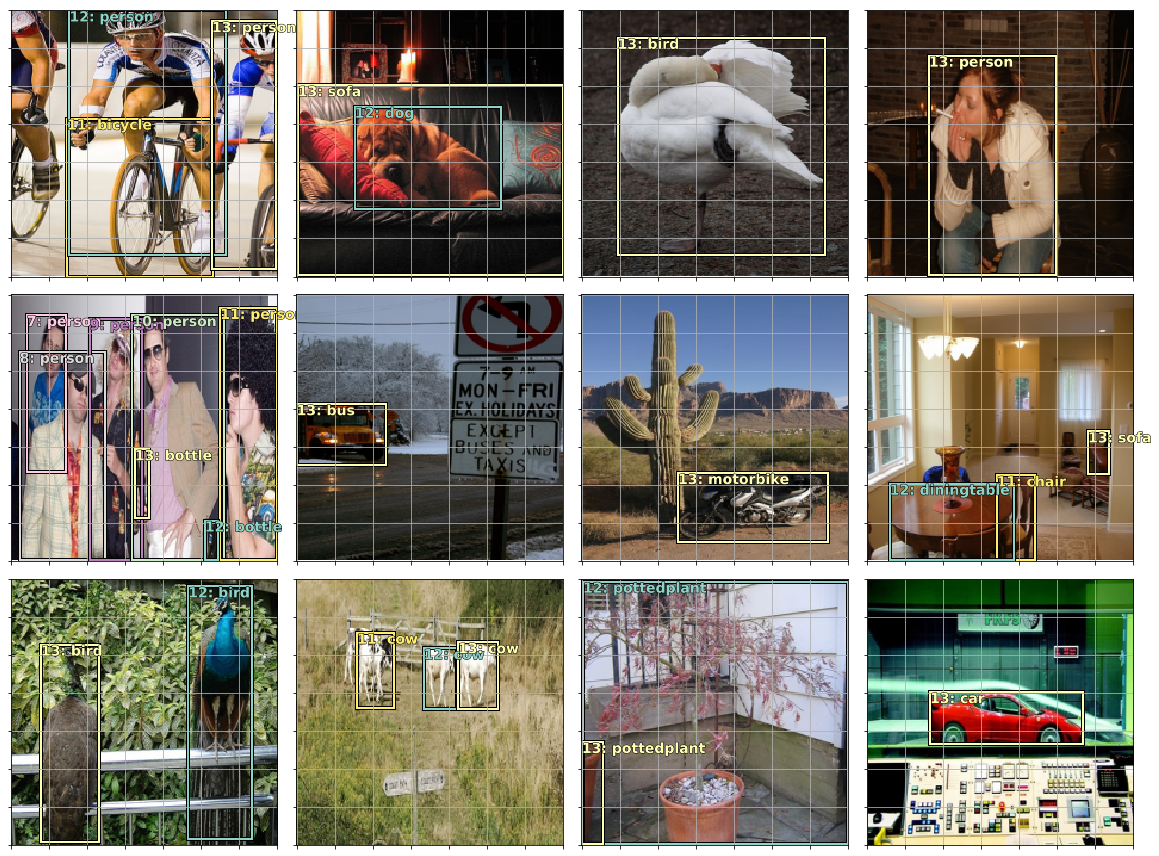

In [317]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i, ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

### 2. Step: Build an architecture

This is going to be a simple first model that predicts what object is in each cell of a 4x4 grid of anchor boxes. We will improve on this later...


In [322]:
anc_grid = 4
k = 1

anc_offset = 1/(anc_grid * 2)
anc_x = np.repeat(np.linspace(start=anc_offset, stop=1-anc_offset, num=anc_grid), anc_grid)

anc_y = np.tile(np.linspace(start=anc_offset, stop=1-anc_offset, num=anc_grid), anc_grid)

In [325]:
anc_centers = np.tile(np.stack([anc_x, anc_y], axis=1), (k,1))

In [331]:
anc_sizes = np.array([[1/anc_grid, 1/anc_grid] for i in range(anc_grid*anc_grid)])

In [333]:
anchors = V(np.concatenate([anc_centers, anc_sizes], axis=1), requires_grad=False).float()

In [334]:
anchors

tensor([[0.1250, 0.1250, 0.2500, 0.2500],
        [0.1250, 0.3750, 0.2500, 0.2500],
        [0.1250, 0.6250, 0.2500, 0.2500],
        [0.1250, 0.8750, 0.2500, 0.2500],
        [0.3750, 0.1250, 0.2500, 0.2500],
        [0.3750, 0.3750, 0.2500, 0.2500],
        [0.3750, 0.6250, 0.2500, 0.2500],
        [0.3750, 0.8750, 0.2500, 0.2500],
        [0.6250, 0.1250, 0.2500, 0.2500],
        [0.6250, 0.3750, 0.2500, 0.2500],
        [0.6250, 0.6250, 0.2500, 0.2500],
        [0.6250, 0.8750, 0.2500, 0.2500],
        [0.8750, 0.1250, 0.2500, 0.2500],
        [0.8750, 0.3750, 0.2500, 0.2500],
        [0.8750, 0.6250, 0.2500, 0.2500],
        [0.8750, 0.8750, 0.2500, 0.2500]], device='cuda:0')

In [338]:
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

In [339]:
grid_sizes

tensor([[0.2500]], device='cuda:0')

(0, 1)

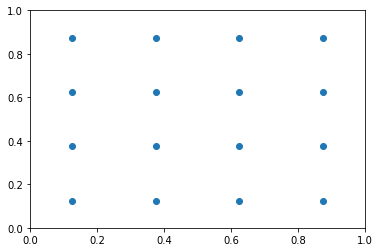

In [341]:
plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0, 1)

**Convert *center and size* to *corners*:**

In [352]:
def hw2corners(center, hw):
    return torch.cat([center-hw/2, center+hw/2], dim=1)

In [353]:
anchor_corners = hw2corners(anchors[:, :2], anchors[:, 2:])

(0, 1)

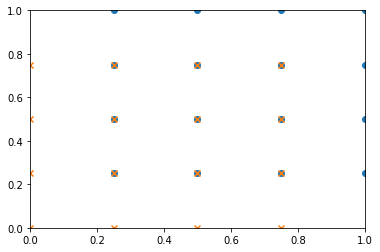

In [358]:
plt.scatter(anchor_corners[:, 2], anchor_corners[:, 3])
plt.scatter(anchor_corners[:, 0], anchor_corners[:, 1],marker='x')
plt.xlim(0, 1)
plt.ylim(0, 1)

In [360]:
n_classes = len(id2cat) + 1  # for 'background'
n_activations = k * (4 + n_classes)  # for bbox coordinates + classes

In [361]:
class StandardConv(nn.Module):
    def __init__(self, n_in, n_out, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(n_in, n_out, kernel_size=3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(n_out)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x):
        return self.drop(self.bn(F.relu(self.conv(x))))
    
def flatten_conv(x, k):
    bs, nf, gx, gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs, -1, nf//k)

In [403]:
class OutConv(nn.Module):
    def __init__(self, k, n_in, bias):
        super(). __init__()
        self.k = k
        # Prediction of classes
        self.oconv1 = nn.Conv2d(n_in, n_classes * k, kernel_size=3, padding=1)
        # Prediction of bbox coordinates
        self.oconv2 = nn.Conv2d(n_in, 4 * k, kernel_size=3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
               flatten_conv(self.oconv2(x), self.k)]

In [404]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StandardConv(512, 256, stride=1)  # keeps size the same because of padding
        self.sconv1 = StandardConv(256, 256)  # reduces size by factor of 2 because of stride=2
        self.out = OutConv(k, 256, bias)
    
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)
        return self.out(x)

In [405]:
custom_head = SSD_Head(k, -3.)
new_model = ConvnetBuilder(model, 0, 0, 0, 0, custom_head=custom_head)

In [406]:
learn = ConvLearner(modeldata, new_model)
learn.opt_fn = optim.Adam

### 3. Step: Define a custom loss function

Anchor boxes:
matching problem: which groundtruth bbox has the highest amount of overlap with the anchor box

jaccard index (IOU index) divide intersection of two boxes by their union